### This project features interactive maps and HTML markup. Since Github does not support dynamic displays for notebooks, it is necessary to download the project to render the elements and to manipulate the data visualizations.

# Data Visualization

This is the <b>third in a series of three Jupyter notebooks</b> on the 2018 Food Consumption and CO<sub>2</sub> Emissions. This activity is in partial fulfillment of the Tidy Tuesdays deliverables for probationary Lyrids of the <b>Center for Complexity and Emerging Technologies, College of Computer Studies, De La Salle University</b>.

<b>Climate change and global warming are pressing environmental issues &mdash; and among the foremost drivers of these are human-induced Emissions of greenhouse gases, such as carbon dioxide (CO<sub>2</sub>)</b>. While this project does not seek to present a professional or rigorous statistical analysis, the author of this series of Jupyter notebooks would like to increase awareness on the importance of data-driven policy directions and to hopefully contribute to the present discourse on how food consumption can greatly impact our carbon footprint. 

<hr/>

The required dataset for this Tidy Tuesdays activity is the 2018 Food Consumption and CO<sub>2</sub> Emissions from the R Community's Tidy Tuesdays (Github): https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-02-18. 

To enrich the analysis and visualization, the following datasets were integrated:

- Country Codes and Names - http://country.io/names.json
- World Bank Country and Lending Groups (Classification for the 2018 Fiscal Year) - https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups

These datasets are stored in the folder <code>data</code> of the repository.

# PRELIMINARIES *(Lifted from Data Preparation)*

<b>Due to restrictions related to the size of files in Github repositories, the project had to be divided into separate notebooks. In this regard, this section is just a repeat of pertinent code excerpts from the data preparation and analysis phases. </b> 

For the complete documentation, please refer to these notebooks: <code>1. Data Preparation.ipynb</code> and <code>2. Data Analysis.ipynb</code>.

In [1]:
import re
import json

import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from pywaffle import Waffle

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected = True)

pd.options.mode.chained_assignment = None  

NUM_ROWS = 10

pd.set_option('display.max_rows', NUM_ROWS)
pd.set_option('display.min_rows', NUM_ROWS)

In [2]:
standardized_names = [("Taiwan. ROC", "Taiwan"),
                      ("USA", "United States"),
                      ("Hong Kong SAR. China", "Hong Kong"),
                      ("Congo", "Republic of the Congo")]

standardized_categories = [("Milk - inc. cheese", "Milk & Cheese"),
                           ("Wheat and Wheat Products", "Wheat & Wheat Products"),
                           ("Nuts inc. Peanut Butter", "Nuts & Peanut Butter")]

In [3]:
data_raw = pd.read_csv('data/food_consumption.csv')
data = data_raw.copy(deep = True)

for name in standardized_names:
    data['country'] = data['country'].str.replace(re.escape(name[0]), name[1])
    
for category in standardized_categories:
    data['food_category'] = data['food_category'].str.replace(re.escape(category[0]), category[1])

In [4]:
animal_products = ['country', 'Beef', 'Eggs', 'Fish', 'Lamb & Goat', 'Milk & Cheese', 'Pork', 'Poultry']
plant_products = ['country', 'Nuts & Peanut Butter', 'Rice', 'Soybeans', 'Wheat & Wheat Products']

In [5]:
country_data = data.pivot(index = 'country', columns = 'food_category', values = 'consumption').reset_index()

country_data['TOTAL'] = country_data['Beef'] + country_data['Eggs'] + country_data['Fish'] \
                        + country_data['Lamb & Goat'] + country_data['Milk & Cheese'] \
                        + country_data['Nuts & Peanut Butter'] + country_data['Pork'] + country_data['Poultry'] \
                        + country_data['Rice'] + country_data['Soybeans'] + country_data['Wheat & Wheat Products']

In [6]:
sorted_country_data = country_data.sort_values(by = 'TOTAL', ascending = False).reset_index(drop = True)
sorted_country_data = sorted_country_data.head(20)

In [7]:
co2_data = data.pivot(index = 'country', columns = 'food_category', values = 'co2_emmission').reset_index()

co2_data['TOTAL'] = co2_data['Beef'] + co2_data['Eggs'] + co2_data['Fish'] \
                    + co2_data['Lamb & Goat'] + co2_data['Milk & Cheese'] \
                    + co2_data['Nuts & Peanut Butter'] + co2_data['Pork'] + co2_data['Poultry'] \
                    + co2_data['Rice'] + co2_data['Soybeans'] + co2_data['Wheat & Wheat Products']

animal_co2_data = co2_data[animal_products]
animal_co2_data['TOTAL'] = animal_co2_data['Beef'] + animal_co2_data['Eggs'] + animal_co2_data['Fish'] \
                               + animal_co2_data['Lamb & Goat'] + animal_co2_data['Milk & Cheese'] \
                               + animal_co2_data['Pork'] + animal_co2_data['Poultry']
    
plant_co2_data = co2_data[plant_products]
plant_co2_data['TOTAL'] = plant_co2_data['Nuts & Peanut Butter'] \
                              + plant_co2_data['Rice'] + plant_co2_data['Soybeans'] \
                              + plant_co2_data['Wheat & Wheat Products']

In [8]:
sorted_co2_data = co2_data.sort_values(by = 'TOTAL', ascending = False).reset_index(drop = True)
sorted_co2_data = sorted_co2_data.head(20)

In [9]:
animal_plant = animal_co2_data[['country', 'TOTAL']]
animal_plant = animal_plant.rename(columns = {"TOTAL": "Animal-Based Food Product Emission"})

animal_plant['Plant-Based Food Product Emission'] = plant_co2_data['TOTAL']
animal_plant['Total'] = animal_plant['Animal-Based Food Product Emission'] + animal_plant['Plant-Based Food Product Emission']
animal_plant['Difference'] = animal_plant['Animal-Based Food Product Emission'] - animal_plant['Plant-Based Food Product Emission']

In [10]:
food_data = data.groupby(['food_category'], as_index = False).sum()

In [11]:
consumption_co2 = country_data[['country','TOTAL']]
consumption_co2 = consumption_co2.rename(columns = {"TOTAL": "Total Consumption"})

consumption_co2['Total CO2 Emission'] = co2_data['TOTAL']

## *More Data Preparation*

In the interest of generating the data visualizations, additional data preparation has to be performed.

### *For Animal-Based vs. Plant-Based Sources*

In order to manage the size of the data visualization, we filter the entries to the highest ten and the ten five animal-to-plant-based emission difference. The code below prepares the reference table for this visualization:

In [12]:
sorted_animal_plant = animal_plant.sort_values(by = 'Difference', ascending = False).reset_index(drop = True)
sorted_animal_plant_head = sorted_animal_plant.head(10)
sorted_animal_plant_tail = sorted_animal_plant.tail(10)

### *For Economics & Mileage of Carbon Footprints*

In order to enrich our analysis and visualization of the economics and mileage of carbon footprints, we import the following CSV file, which we constructed from the data provided by the World Bank on country and lending groups, accessible via this link: https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups. 

Essentially, countries are tagged depending on their economy:
- Low income
- Lower middle income
- Upper middle income
- High income

In [13]:
economies = pd.read_csv('data/countries_by_income.csv', encoding = 'ISO-8859-1')
economies

,country,code,geography,economy
0,Afghanistan,AFG,South Asia,Low income
1,Albania,ALB,Europe & Central Asia,Upper middle income
2,Algeria,DZA,Middle East & North Africa,Lower middle income
3,American Samoa,ASM,East Asia & Pacific,Upper middle income
4,Andorra,AND,Europe & Central Asia,High income
...,...,...,...,...
213,Virgin Islands (U.S.),VIR,Latin America & Caribbean,High income
214,West Bank and Gaza,PSE,Middle East & North Africa,Lower middle income
215,"Yemen, Rep.",YEM,Middle East & North Africa,Low income
216,Zambia,ZMB,Sub-Saharan Africa,Lower middle income


We merge this World Bank classification with our current dataset. 

*Since we are expecting discrepancies between country names, we will use **right join** in order to identify the country names in our dataset that are different from those in the World Bank classification.*

In [14]:
countries_economies = pd.merge(economies, country_data, on = ['country', 'country'], how = 'right')
countries_economies

,country,code,geography,economy,Beef,Eggs,Fish,Lamb & Goat,Milk & Cheese,Nuts & Peanut Butter,Pork,Poultry,Rice,Soybeans,Wheat & Wheat Products,TOTAL
0,Albania,ALB,Europe & Central Asia,Upper middle income,22.50,12.45,3.85,15.32,303.72,4.36,10.88,13.23,7.78,0.00,138.64,532.73
1,Algeria,DZA,Middle East & North Africa,Lower middle income,5.60,8.06,3.74,7.69,141.53,2.08,0.00,7.42,2.97,0.00,185.42,364.51
2,Angola,AGO,Sub-Saharan Africa,Lower middle income,8.42,1.11,15.24,1.08,12.30,2.26,8.89,17.33,8.12,0.52,40.72,115.99
3,Argentina,ARG,Latin America & Caribbean,Upper middle income,55.48,11.39,4.36,1.56,195.08,0.49,10.51,38.66,8.77,0.00,103.11,429.41
4,Armenia,ARM,Europe & Central Asia,Upper middle income,19.66,11.69,4.36,3.02,209.03,2.55,9.67,13.35,3.18,0.00,130.60,407.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,Slovakia,NaN,NaN,NaN,5.19,16.05,8.39,0.16,143.14,3.70,31.78,15.13,2.88,0.02,123.62,350.06
126,South Korea,NaN,NaN,NaN,14.53,11.24,33.09,0.14,29.05,4.88,32.76,16.00,85.18,8.35,50.84,286.06
127,Swaziland,NaN,NaN,NaN,15.10,1.50,1.26,1.94,56.60,6.44,2.43,6.18,21.15,0.55,37.15,150.30
128,Taiwan,NaN,NaN,NaN,5.21,13.08,18.29,0.92,41.72,9.06,39.37,32.13,45.85,16.95,50.92,273.50


Entries with null values correspond to the country names in our dataset that are different from those in the World Bank classification.

In [15]:
countries_economies_null = countries_economies[countries_economies.isna().any(axis = 1)]
print(list(countries_economies_null['country']))

['Bahamas', 'Egypt', 'Gambia', 'Hong Kong', 'Iran', 'Macedonia', 'Republic of the Congo', 'Russia', 'Slovakia', 'South Korea', 'Swaziland', 'Taiwan', 'Venezuela']


In this regard, a list, <code>standardized_names_economies</code>, consisting of tuples is constructed. The first element in each tuple refers to the name in the World Bank classification while the second element refers to the name in our dataset. We will use this list in order to update the values in the World Bank classification.

In [16]:
standardized_names_economies = [("Bahamas, The", "Bahamas"),
                               ("Egypt, Arab Rep.", "Egypt"),
                               ("Gambia, The", "Gambia"),
                               ("Hong Kong SAR, China", "Hong Kong"),
                               ("Iran, Islamic Rep.", "Iran"),
                               ("North Macedonia", "Macedonia"),
                               ("Congo, Rep.", "Republic of the Congo"),
                               ("Russian Federation", "Russia"),
                               ("Slovak Republic", "Slovakia"),
                               ( "Korea, Rep.", "South Korea"),
                               ("Eswatini", "Swaziland"),
                               ("Taiwan, China", "Taiwan"),
                               ("Venezuela, RB", "Venezuela")]

for name in standardized_names_economies:
    economies['country'] = economies['country'].str.replace(re.escape(name[0]), name[1])
    
print(economies['country'].unique())

['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'British Virgin Islands'
 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde'
 'Cambodia' 'Cameroon' 'Canada' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Channel Islands' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo, Dem. Rep.' 'Republic of the Congo'
 'Costa Rica' "Côte d'Ivoire" 'Croatia' 'Cuba' 'Curaçao' 'Cyprus'
 'Czech Republic' 'Denmark' 'Djibouti' 'Dominica' 'Dominican Republic'
 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia'
 'Swaziland' 'Ethiopia' 'Faroe Islands' 'Fiji' 'Finland' 'France'
 'French Polynesia' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana'
 'Gibraltar' 'Greece' 'Greenland' 'Grenada' 'Guam' 'Guatemala' '

Finally, we merge the two datasets, remove unneeded columns (e.g., the country code and the geographical classification), and confirm that there are no null values.

In [17]:
countries_economies = pd.merge(economies, country_data, on = ['country', 'country'], how = 'right')
countries_economies.drop(columns = ['code', 'geography'], axis = 1, inplace = True)

countries_economies

,country,economy,Beef,Eggs,Fish,Lamb & Goat,Milk & Cheese,Nuts & Peanut Butter,Pork,Poultry,Rice,Soybeans,Wheat & Wheat Products,TOTAL
0,Albania,Upper middle income,22.50,12.45,3.85,15.32,303.72,4.36,10.88,13.23,7.78,0.00,138.64,532.73
1,Algeria,Lower middle income,5.60,8.06,3.74,7.69,141.53,2.08,0.00,7.42,2.97,0.00,185.42,364.51
2,Angola,Lower middle income,8.42,1.11,15.24,1.08,12.30,2.26,8.89,17.33,8.12,0.52,40.72,115.99
3,Argentina,Upper middle income,55.48,11.39,4.36,1.56,195.08,0.49,10.51,38.66,8.77,0.00,103.11,429.41
4,Armenia,Upper middle income,19.66,11.69,4.36,3.02,209.03,2.55,9.67,13.35,3.18,0.00,130.60,407.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,Uruguay,High income,29.10,13.14,6.53,8.23,210.54,0.95,16.84,27.45,11.50,0.01,109.31,433.60
126,Venezuela,Upper middle income,25.89,5.63,8.34,0.32,117.79,0.35,7.23,39.28,23.39,0.00,49.17,277.39
127,Vietnam,Lower middle income,7.44,3.84,26.52,0.14,16.36,6.28,35.00,12.36,144.56,5.75,10.49,268.74
128,Zambia,Lower middle income,4.76,3.32,6.20,0.68,9.71,5.04,1.66,3.29,3.05,7.30,12.10,57.11


<hr/>

## A. Global Map of Food Consumption & CO<sub>2</sub> Emissions

For our first data visualization, we construct a dynamic choropleth map of the food consumption of countries around the world. 

*Note that this is an interactive map. Hovering allows for a more granular look at the data.*

In [18]:
fig = px.choropleth(country_data,
                    locations = "country",
                    locationmode = "country names",
                    color = "TOTAL",
                    hover_name = "country",
                    hover_data = animal_products + plant_products,
                    height = 700,
                    color_continuous_scale = "PuBuGn")

fig.update_layout(title = "Global Food Consumption (in kg/person/year)")

fig.show()

Countries with the highest record of food product consumption are concentrated in Europe &mdash; as evidenced by the dark gradient on this continent &mdash; with Finland being the top consumer (639.79 kg/person/year). It is to be noted that the European Union is the biggest cheese and skin milk powder exporter globally, as well as the second-largest producer and the foremost exporter of pork in the world (European Union, 2021).

On the other hand, the countries with the lowest record of food product consumption are concentrated in Africa &mdash; as evidenced by the paler gradient on this region &mdash; with Rwanda being the lowest consumer (40 kg/person/year). This trend may possibly indicate a relationship between the economy of a country and consumption. Consumption is intrinsically tied with the available resources of a country. In particular, countries with enough or above-adequate resources for the production and even participate in the trade of goods also tend to have a more ample supply of food products (either locally produced or imported) for the consumption of their citizens. 

These observations are further supported by the supplementary bar graph visualization below.

*Note that this is an interactive graph. Hovering allows for a more granular look at the data.*

In [19]:
fig = go.Figure(data = [
    go.Bar(orientation = 'h',
          y = sorted_country_data['country'],
          x = sorted_country_data['Beef'],
          name = 'Beef'),
    go.Bar(orientation = 'h',
          y = sorted_country_data['country'],
          x = sorted_country_data['Eggs'],
          name = 'Eggs'),
    go.Bar(orientation = 'h',
          y = sorted_country_data['country'],
          x = sorted_country_data['Fish'],
          name = 'Fish'),
    go.Bar(orientation = 'h',
          y = sorted_country_data['country'],
          x = sorted_country_data['Lamb & Goat'],
          name = 'Lamb & Goat'),
    go.Bar(orientation = 'h',
          y = sorted_country_data['country'],
          x = sorted_country_data['Milk & Cheese'],
          name = 'Milk & Cheese'),
    go.Bar(orientation = 'h',
          y = sorted_country_data['country'],
          x = sorted_country_data['Pork'],
          name = 'Pork'),
    go.Bar(orientation = 'h',
          y = sorted_country_data['country'],
          x = sorted_country_data['Poultry'],
          name = 'Poultry'),
    go.Bar(orientation = 'h',
          y = sorted_country_data['country'],
          x = sorted_country_data['Nuts & Peanut Butter'],
          name = 'Nuts & Peanut Butter'),
    go.Bar(orientation = 'h',
          y = sorted_country_data['country'],
          x = sorted_country_data['Rice'],
          name = 'Rice'),
    go.Bar(orientation = 'h',
          y = sorted_country_data['country'],
          x = sorted_country_data['Soybeans'],
          name = 'Soybeans'),
    go.Bar(orientation = 'h',
          y = sorted_country_data['country'],
          x = sorted_country_data['Wheat & Wheat Products'],
          name = 'Wheat & Wheat Products',
          marker_color = 'sandybrown')
])

fig.update_layout(barmode = 'stack',
                 yaxis = dict(autorange = 'reversed'),
                 title = "Food Product Consumption of Top 20 Consumers",
                 xaxis_title = "Consumption (kg/person/year)",
                 yaxis_title = "Country")

fig.show()

Among these 20 states, there is a noticeably high consumption of milk and cheese, followed by wheat and wheat products (with the notable exception of the small archipelagic South Asian nation of Maldives, in which fish comes second), although the consumption of milk and cheese far outweighs the others, contributing to over half of these nations' total consumption. 

We are also interested in creating a choropleth map of the food product-related carbon dioxide emission of countries around the world.

*Note that this is an interactive map. Hovering allows for a more granular look at the data.*

In [20]:
fig = px.choropleth(co2_data,
                    locations = "country",
                    locationmode = "country names",
                    color = "TOTAL",
                    hover_name = "country",
                    hover_data = animal_products + plant_products,
                    height = 700,
                    color_continuous_scale = "YlOrRd")

fig.update_layout(title = "Global Food Product-Related Carbon Dioxide Emission (in kg CO<sub>2</sub>/person/year)")

fig.show()

Unlike consumption, there is no clear trend as regards the geographical concentration of the countries with the highest amount of CO<sub>2</sub> emissions. They come from different regions: South America (Argentina, Uruguay, and Brazil), Oceania (Australia and New Zealand), Europe (Albania, Iceland, and Luxembourg), Central Asia (Kazakhstan), and the United States. The highest emission is recorded by Argentina at 2172.4 kg CO<sub>2</sub>/kg/year. 

The overall top emitter Argentina is also the top emitter of beef-related CO<sub>2</sub> at 1712 kg CO<sub>2</sub>/kg/year, accounting for 78.82% of its total emission. Meanwhile, Iceland, which also happens to be the top consumer of lamb and goat food products, is also the top emitter for the same food category, at 739.62 kg CO<sub>2</sub>/kg/year, which corresponds to around 42.72% of its total emission.

On the other hand, countries with the lowest record of food product-related emission are concentrated in Africa, with Mozambique recording the lowest emission (141.4 kg CO<sub>2</sub>/person/year), followed by Rwanda at 181.63 kg CO<sub>2</sub>/person/year. Interestingly, Rwanda also happens to be the lowest food product consumer. In fact, there is a noticeable overlap between the ten lowest emitters although their placements are shuffled. The Republic of the Congo is the only country in the ten lowest emitters that is not in the ten lowest consumers as well (Cameroon is included instead). 

These observations are further supported by the supplementary bar graph visualization below.

*Note that this is an interactive graph. Hovering allows for a more granular look at the data.*

In [21]:
fig = go.Figure(data = [
    go.Bar(orientation = 'h',
          y = sorted_co2_data['country'],
          x = sorted_co2_data['Beef'],
          name = 'Beef'),
    go.Bar(orientation = 'h',
          y = sorted_co2_data['country'],
          x = sorted_co2_data['Eggs'],
          name = 'Eggs'),
    go.Bar(orientation = 'h',
          y = sorted_co2_data['country'],
          x = sorted_co2_data['Fish'],
          name = 'Fish'),
    go.Bar(orientation = 'h',
          y = sorted_co2_data['country'],
          x = sorted_co2_data['Lamb & Goat'],
          name = 'Lamb & Goat'),
    go.Bar(orientation = 'h',
          y = sorted_co2_data['country'],
          x = sorted_co2_data['Milk & Cheese'],
          name = 'Milk & Cheese'),
    go.Bar(orientation = 'h',
          y = sorted_co2_data['country'],
          x = sorted_co2_data['Pork'],
          name = 'Pork'),
    go.Bar(orientation = 'h',
          y = sorted_co2_data['country'],
          x = sorted_co2_data['Poultry'],
          name = 'Poultry'),
    go.Bar(orientation = 'h',
          y = sorted_co2_data['country'],
          x = sorted_co2_data['Nuts & Peanut Butter'],
          name = 'Nuts & Peanut Butter'),
    go.Bar(orientation = 'h',
          y = sorted_co2_data['country'],
          x = sorted_co2_data['Rice'],
          name = 'Rice'),
    go.Bar(orientation = 'h',
          y = sorted_co2_data['country'],
          x = sorted_co2_data['Soybeans'],
          name = 'Soybeans'),
    go.Bar(orientation = 'h',
          y = sorted_co2_data['country'],
          x = sorted_co2_data['Wheat & Wheat Products'],
          name = 'Wheat & Wheat Products',
          marker_color = 'sandybrown')
])

fig.update_layout(barmode = 'stack',
                 yaxis = dict(autorange = 'reversed'),
                 title = "Food Product-Related CO<sub>2</sub> Emission of Top 20 Emitters",
                 xaxis_title = "Emission (kg CO<sub>2</sub>/person/year)",
                 yaxis_title = "Country")

fig.show()

Beef and milk and cheese are the primary contributory products to emission although the proportion of emission due to the latter is less pronounced compared to their consumption. It may be fitting to point out that both of these food products are derived from cows. Their high carbon footprint compared to other food products is unsurprising; as Quinton (2019) of the University of California, Davis, pointed out, cattle (to which cows belong) are the foremost agricultural sources of greenhouse gases due to the high "hoofprint" of their belches and feces.

<hr/>

## B. Philippine Context

It may also be interesting to take a look at how our country (the Philippines) is situated in these global statistics. 

### 1. Consumption

In [22]:
ph_data = country_data.loc[country_data['country'] == 'Philippines']
ph_data

food_category,country,Beef,Eggs,Fish,Lamb & Goat,Milk & Cheese,Nuts & Peanut Butter,Pork,Poultry,Rice,Soybeans,Wheat & Wheat Products,TOTAL
93,Philippines,4.06,4.02,28.51,0.56,15.66,2.08,18.4,11.91,119.44,0.03,23.12,227.79


The Philippines is 94<sup>th</sup> in terms of consumption of food products.

Among these, the top three food products consumed are rice, fish, and wheat and wheat products. *Under the hood, we convert the total figures to percentages for a more efficient generation of the data visualization.*

In [23]:
ph_rice = round(float(ph_data['Rice'] * 100 / ph_data['TOTAL']))
ph_fish = round(float(ph_data['Fish'] * 100 / ph_data['TOTAL']))
ph_wheat = float(ph_data['Wheat & Wheat Products'] * 100 / ph_data['TOTAL'])

ph_others = 100 - ph_rice - ph_fish - ph_wheat

The waffle chart below shows that around 52% of our total consumption can be ascribed to rice, 13% to fish, 10% to wheat and wheat products, and 25% to the remaining food categories.

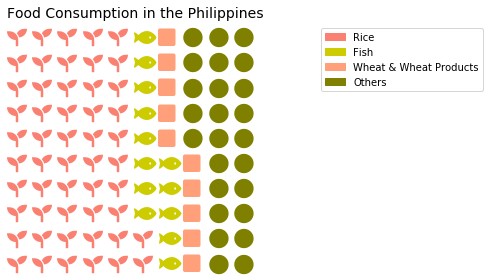

In [24]:
fig = plt.figure(
    FigureClass = Waffle,
    rows = 10,
    columns = 10,
    values = [ph_rice, ph_fish, ph_wheat, ph_others],
    icons = ['seedling', 'fish', 'square', 'circle'],
    colors = ['salmon', '#CCCC00', 'lightsalmon', 'olive'],
    font_size = 20,
    legend = {
        'labels': ['Rice', 'Fish', 'Wheat & Wheat Products', 'Others'], 
        'loc': 'upper left', 
        'bbox_to_anchor': (1.25, 1)
    },
    title={
        'label': 'Food Consumption in the Philippines',
        'loc': 'left',
        'fontdict': {
            'fontsize': 14
        }
    }
)

### 2. Carbon Dioxide Emission

In [25]:
ph_co2_data = co2_data.loc[country_data['country'] == 'Philippines']
ph_co2_data

food_category,country,Beef,Eggs,Fish,Lamb & Goat,Milk & Cheese,Nuts & Peanut Butter,Pork,Poultry,Rice,Soybeans,Wheat & Wheat Products,TOTAL
93,Philippines,125.28,3.69,45.52,19.61,22.31,3.68,65.13,12.79,152.85,0.01,4.41,455.28


The Philippines is also 94<sup>th</sup> in terms of carbon dioxide emission.

Among these, the top three food products associated with emissions are rice, beef, and wheat and pork. *Under the hood, we convert the total figures to percentages for a more efficient generation of the data visualization.*

In [26]:
ph_co2_rice = round(float(ph_co2_data['Rice'] * 100 / ph_co2_data['TOTAL']))
ph_co2_beef = round(float(ph_co2_data['Beef'] * 100 / ph_co2_data['TOTAL']))
ph_co2_pork = float(ph_co2_data['Pork'] * 100 / ph_co2_data['TOTAL'])

ph_co2_others = 100 - ph_co2_rice - ph_co2_beef - ph_co2_pork

The waffle chart below shows that around 34% of our total carbon dioxide emission can be ascribed to rice, 28% to beef, 14% to pork, and 24% to the remaining food categories.

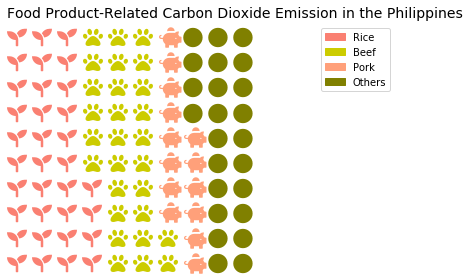

In [27]:
fig = plt.figure(
    FigureClass = Waffle,
    rows = 10,
    columns = 10,
    values = [ph_co2_rice, ph_co2_beef, ph_co2_pork, ph_co2_others],
    icons = ['seedling', 'paw', 'piggy-bank', 'circle'],
    colors = ['salmon', '#CCCC00', 'lightsalmon', 'olive'],
    font_size = 20,
    legend = {
        'labels': ['Rice', 'Beef', 'Pork', 'Others'], 
        'loc': 'upper left', 
        'bbox_to_anchor': (1.25, 1)
    },
    title={
        'label': 'Food Product-Related Carbon Dioxide Emission in the Philippines',
        'loc': 'left',
        'fontdict': {
            'fontsize': 14
        }
    }
)

These proportions are explained by the fact that rice is the staple of Filipinos. Although it can sequester carbon dioxide to an extent, it is also known to produce other greenhouse gases, particularly methane (especially when it is grown on flooded plots). 

From a global lens, the conducted data analysis showed that the Philippines is the 6th highest emitter of plant-based food product-related carbon dioxide at 160.95 kg CO2/person/year. In addition, in the ten countries that recorded the highest emission related to plant-based food products &mdash; most of which are also in Southeast Asia &mdash; emission due to rice far outweighs the others, with close to 98% of the gross emission attributed to the said crop.

<hr/>

## C. Animal-Based vs. Plant-Based Food Sources

One of the angles explored in this project is the potential relationship between the food source and the gross carbon dioxide emission. In the data analysis phase, we have established via Pearson's *r* that there exists a very high positive correlation between the predominant food source of a country (that is, its "inclination" to plants as the predominant source) and its carbon dioxide emission, as can be gleaned visually in the scatterplot below:

*Note that this is an interactive plot. Hovering allows for a more granular look at the data.*

In [28]:
fig = go.Figure(data = [
    go.Scatter(x = animal_plant['Difference'],
          y = animal_plant['Total'],
          mode = 'markers')
])

fig.update_layout(title = "Total Country-Level Emission versus Animal-to-Plant-Based Emission Difference",
                 xaxis_title = "Total Country-Level Emission (kg CO<sub>2</sub>/person/year)",
                 yaxis_title = "Animal-to-Plant-Based Emission Difference (kg CO<sub>2</sub>/person/year)")

fig.show()

The bar graph below gives a country-level overview of these animal-to-plant-based emission differences. As explained by the creators of the dataset, nu3 (2018), a lower value of this difference metric is indicative that a larger proportion of the country's population consumes plant-based food products. Consequently, a negative value implies that plants (rather than the more common animals) serve as the primary food source of the country. 

To manage the size of the data visualization, we limit the entries in the graph to the highest ten and the ten five animal-to-plant-based emission difference. 

*Note that this is an interactive graph. Hovering allows for a more granular look at the data.*

In [29]:
fig = go.Figure(data = [
    go.Bar(orientation = 'h',
          y = sorted_animal_plant_head['country'],
          x = sorted_animal_plant_head['Difference'],
          name = 'Top 10: Plant-Based over Animal-Based Food'),
    go.Bar(orientation = 'h',
          y = sorted_animal_plant_tail['country'],
          x = sorted_animal_plant_tail['Difference'],
          name = 'Top 10: Animal-Based over Plant-Based Food')
])

fig.update_layout(yaxis = dict(autorange = 'reversed'),
                  xaxis_title = "Animal-to-Plant-Based Emission Difference (kg CO<sub>2</sub>/person/year)",
                  yaxis_title = "Country")

fig.show()

Notice that, among the 130 countries in the entire dataset, there are only two countries with a negative difference: Liberia and Bangladesh. 

**To further put things into perspective, it may also be helpful to visualize how animal- and plant-based food products contribute to the gross carbon dioxide emission worldwide.**

First, we perform the necessary computations and convert numerical figures into percentages for a more efficient generation of the visualization. Note that the food products are split into beef, milk and cheese, animal-based products (excluding the previous two), and plant-based products to represent the four major classifications based on earlier analyses.

In [30]:
NUM_COUNTRIES = len(animal_plant)

total_animal_plant = animal_plant.append(animal_plant.sum(numeric_only = True), ignore_index = True)

total_animal = total_animal_plant.loc[NUM_COUNTRIES]['Animal-Based Food Product Emission']
total_plant = total_animal_plant.loc[NUM_COUNTRIES]['Plant-Based Food Product Emission']

total_beef = float(food_data.loc[food_data['food_category'] == 'Beef']['co2_emmission'])
total_cheese = float(food_data.loc[food_data['food_category'] == 'Milk & Cheese']['co2_emmission'])

total_beef = round(total_beef * 100 / (total_animal + total_plant))
total_cheese = round(total_cheese * 100 / (total_animal + total_plant))
total_animal = round(total_animal * 100 / (total_animal + total_plant))
total_animal_no_beef_cheese = total_animal - total_beef - total_cheese
total_plant = 100.0 - total_animal_no_beef_cheese - total_beef - total_cheese

We are now ready to generate the waffle chart. It can be seen that 46% of the world's total food product-related carbon dioxide emission can be ascribed to beef, 22% to milk and cheese, 25% to other animal-based food products, and 7% to plant-based food products. 

Taking the first three categories collectively, 93% of the gross food product-related CO<sub>2</sub> emission is due to animal-based food products alone.

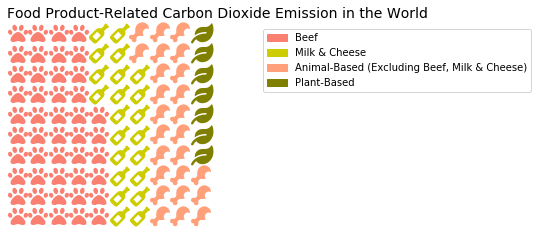

In [31]:
fig = plt.figure(
    FigureClass = Waffle,
    rows = 10,
    columns = 10,
    values = [total_beef, total_cheese, total_animal_no_beef_cheese, total_plant],
    icons = ['paw', 'wine-bottle', 'drumstick-bite', 'leaf'],
    colors = ['salmon', '#CCCC00', 'lightsalmon', 'olive'],
    font_size = 20,
    legend = {
        'labels': ['Beef', 'Milk & Cheese', 'Animal-Based (Excluding Beef, Milk & Cheese)', 'Plant-Based'], 
        'loc': 'upper left', 
        'bbox_to_anchor': (1.25, 1)
    },
    title={
        'label': 'Food Product-Related Carbon Dioxide Emission in the World',
        'loc': 'left',
        'fontdict': {
            'fontsize': 14
        }
    }
)

Although giving a conclusive answer as to whether a certain type of diet must be preferred by individuals to significantly mitigate their carbon footprint is outside the scope of the data at hand, the results of this project have established a strong correlation between the predominant food source of a country and its food product-related CO<sub>2</sub> emission. 

<hr/>

## D. Economics & Mileage of Carbon Footprints

Numerous studies have explored the dynamics between the economic growth of countries and their carbon footprints. In the data analysis phase of this project, an economic facet that has been explored is the interplay between consumption and emission. This is founded on the assumption that states that are able to sustain a beyond-sufficient food supply for the consumption of their citizens are most likely to also have above-adequate resources for production or participation in regional or transnational trade of goods. 

Empirically, this can be gleaned in the observation that most of the top emitters have developed economies while most of the countries with the least emissions are characterized by low-income economies. Treating consumption as an economic marker, a statistical correlation has also been established in the data analysis phase &mdash; there exists a high positive correlation between correlation and CO<sub>2</sub> emission, as seen in the scatterplot below:

*Note that this is an interactive plot. Hovering allows for a more granular look at the data.*

In [32]:
fig = go.Figure(data = [
    go.Scatter(x = consumption_co2['Total Consumption'],
          y = consumption_co2['Total CO2 Emission'],
          mode = 'markers')
])

fig.update_layout(title = "Total Country-Level Consumption versus Total CO<sub>2</sub> Emission",
                 xaxis_title = "Total Consumption (kg/person/year)",
                 yaxis_title = "Total CO<sub>2</sub> Emission (kg CO<sub>2</sub>/person/year)")
fig.show()

We now proceed to a more direct analysis and visualization of the economics of carbon footprints. Using the economic classification of countries given by the World Bank for the 2018 fiscal year (as explained in the *More Data Preparation* section of this notebook), the total carbon dioxide emission per economic classification is computed.

In [33]:
economies_co2 = countries_economies.groupby(['economy'], as_index = False).sum()
economies_co2 = economies_co2.sort_values(by = 'TOTAL', ascending = False).reset_index(drop = True)

economies_co2

,economy,Beef,Eggs,Fish,Lamb & Goat,Milk & Cheese,Nuts & Peanut Butter,Pork,Poultry,Rice,Soybeans,Wheat & Wheat Products,TOTAL
0,High income,891.01,590.25,1113.10,192.05,10219.76,283.21,1508.28,1581.67,866.64,49.53,4771.82,22067.32
1,Upper middle income,451.95,341.52,588.20,81.92,4250.35,111.16,424.61,832.05,1010.39,30.25,2760.48,10882.88
2,Lower middle income,189.20,116.47,427.06,46.57,1611.10,103.04,138.67,309.26,1399.29,27.27,1587.14,5955.07
3,Low income,43.88,13.05,118.96,17.48,269.50,40.43,24.52,35.52,542.45,4.82,182.00,1292.61


**An interesting statistic to be included in the bar graph generated below is the "mileage" of carbon dioxide emission.** 

Oftentimes, it is easy to take the carbon footprint of food production for granted since most of us are on the consuming side. However, the volume of carbon dioxide and greenhouse gas emission from farm gates alone (not even including additional footprint left by the transportation of these products and wastage) is comparable to that from a more familiar example of a climate change-contributory habit &mdash; driving petrol-fueled vehicles. 

The computation used here is borrowed from the information provided by Stylianou, Guibourg, and Briggs of BBC (2019): <blockquote>[D]riving a regular petrol car produces 392g of CO<sub>2</sub>/mile over its entire lifecycle, including emissions from the vehicle's production, fuel production and exhaust emissions per mile.</blockquote>

In [34]:
# Divide 392g by 1000 since this project uses kg
MILEAGE_CONVERSION = 0.392

mileage = economies_co2['TOTAL'] / MILEAGE_CONVERSION
mileage = ['%.2f miles' % m for m in mileage]

*Note that this is an interactive graph. Hovering allows for a more granular look at the data.*

In [35]:
fig = go.Figure(data = [
    go.Bar(x = economies_co2['economy'],
          y = economies_co2['TOTAL'],
          text = mileage,
          name = 'Consumption',
          textposition = 'auto')
])

fig.update_layout(title = "Total Carbon Dioxide Emission per Income-Based Economic Classification",
                  xaxis_title = "Economic Classifications",
                  yaxis_title = "Total Carbon Dioxide Emission (in kg CO<sub>2</sub>/person/year)")

fig.show()

The bar graph above shows the great disparity among the carbon footprints of economies:
- The gross emission of high-income economies (22.07 thousand kg CO<sub>2</sub>/person/year, or around 56294.18 miles) is over twice that of upper-middle-income economies (10.88 thousang kg CO<sub>2</sub>/person/year, or around 27762.45 miles)
- The gross emission of upper-middle-income economies, in turn, is roughly twice that of lower-middle-income economies (5.96 thousand  kg CO<sub>2</sub>/person/year, or around 15191.51 miles). 
- The gap widens, as the gross emission of lower-middle-income economies is roughly five times that of low-income economies (1.29 thousand kg CO<sub>2</sub>/person/year, or around 3297.47 miles).

*Nonetheless, this still comes with the postscript that eating, unlike other "optional" anthropogenic contributors to climate change (e.g., using petrol-powered cars and traveling by air), is a requisite human activity &mdash; with strong ties to personal preferences, cultural praxes, national demand and supply, and socioeconomic considerations &mdash; that we cannot alter that easily.*

*A more feasible solution would begin at the scientific or institutional level, focusing on the development of more sustainable technologies or practices and lobbying for stronger policy implementations related to the production, distribution, and consumption chain of these agricultural necessities.* 

# References

- European Union. (2021). *Animal products*. https://ec.europa.eu/info/food-farming-fisheries/animals-and-animal-products/animal-products/
- Mottaleb, K., Rahut, D.N., Kruseman, G., & Erenstein, O. (2017). Wheat production and consumption dynamics in an Asian rice economy: The Bangladesh case. *European Journal of Development Research, 30*(1), 1-24. doi:10.1057/s41287-017-0096-1
- nu3. (2018). *Food carbon footprint index 2018*. https://www.nu3.de/blogs/nutrition/food-carbon-footprint-index-2018
- Quinton, A. (2019, June 27). *Cows and climate change*. University of California, Davis. https://www.ucdavis.edu/food/news/making-cattle-more-sustainable
- Stylianou, N., Guibourg, C., & Briggs, H. (2019, August 9). *Climate change calculator: What's your diet's carbon footprint?* https://www.bbc.com/news/science-environment-46459714
- World Health Organization. (n.d.). *Congo*. https://www.who.int/countries/cog/